In [185]:
%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

from pandas.plotting import autocorrelation_plot
from pandas.plotting import lag_plot
from statsmodels.graphics.tsaplots import plot_acf;
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA
from sklearn.metrics import mean_squared_error
from datetime import datetime

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

matplotlib.style.use('ggplot')

In [10]:
def parse_date_month(d):
    parsed = d.split(" ")[0].split("/")
    return parsed[2]+ "-" + parsed[0]

In [3]:
df = pd.read_csv("../data/crimes_in_polygon.csv")
df = df[["ID", "Date", "Year", "Zip"]]
df["Month"] = df["Date"].apply(parse_date_month)
df["Month"] = pd.to_datetime(df["Month"])

Overall crime rate in Chicago

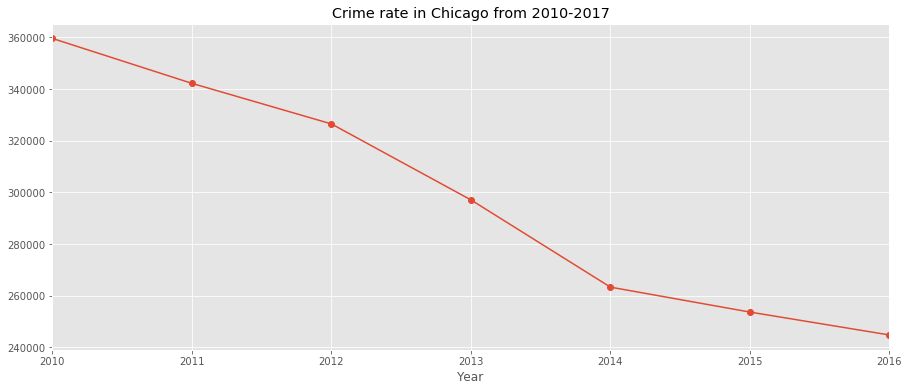

In [11]:
df_by_year = df.groupby("Year").count().ID
df_by_year.plot(title="Crime rate in Chicago from 2010-2017", marker='o')

It seems that the trend in number of crimes is going down. However let's see the same data by monthly.

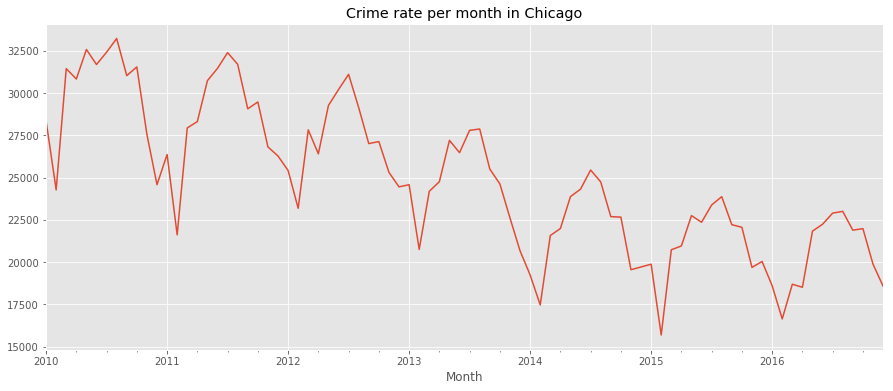

In [59]:
df_by_month = df.groupby("Month").count().ID
df_by_month.plot(title="Crime rate per month in Chicago");

To see months were crime rates were lowest and highest in 2010 and 2016:

In [13]:
df_by_month["2010"].argmin()
df_by_month["2010"].argmax()

df_by_month["2016"].argmin()
df_by_month["2016"].argmax()

Timestamp('2010-02-01 00:00:00')

Timestamp('2010-08-01 00:00:00')

Timestamp('2016-02-01 00:00:00')

Timestamp('2016-08-01 00:00:00')

Interestingly they are exactly same. This phenomena is visible in every year cycle. 

Overall, clearly there exists much more fluctuations when visualizing by months, but the trend still seems to be going down. There also exists seasonal changes, as for example crime rates are lowest after the New Year, but highest around summertime. These times of year, also are coldest/warmest months in Chicago.

Next, to get insight to areal differences, lets compare crime rate in ZIP-codes where it's the minimum, median and maximum.

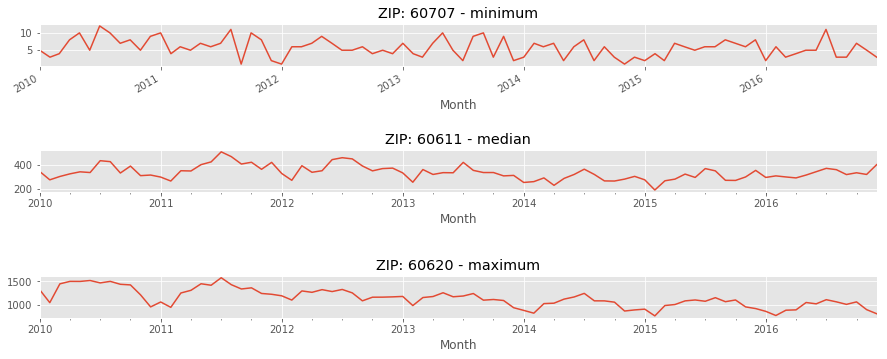

In [69]:
df_z = df.groupby("Zip").count().ID
df_z_m = df.groupby(["Zip", "Month"]).count().ID

min_zip = df_z.argmin()
med_zip = df_z[df_z == df_z.median()].index[0]
max_zip = df_z.argmax()

fig, axes = plt.subplots(nrows=3);
plt.subplots_adjust(hspace = 2);

df_z_m[min_zip].plot(ax=axes[0]);
axes[0].set_title("ZIP: " + str(min_zip) + " - minimum");

df_z_m[med_zip].plot(ax=axes[1]);
axes[1].set_title("ZIP: " + str(med_zip) + " - median");

df_z_m[max_zip].plot(ax=axes[2]);
axes[2].set_title("ZIP: " + str(max_zip) + " - maximum");

Median and maximum crime areas seems to have the same seasonal changes as seen in a big picture. Both lowering when the year has turned, and rising at summer.

To find out how randomized the overall timeseries is, we next plot it via autocorrelation and lag plots.

```
AC is done by computing autocorrelations for data values at varying time lags. If time series is random, such autocorrelations should be near zero for any and all time-lag separations. If time series is non-random then one or more of the autocorrelations will be significantly non-zero. The horizontal lines displayed in the plot correspond to 95% and 99% confidence bands. The dashed line is 99% confidence band.
```

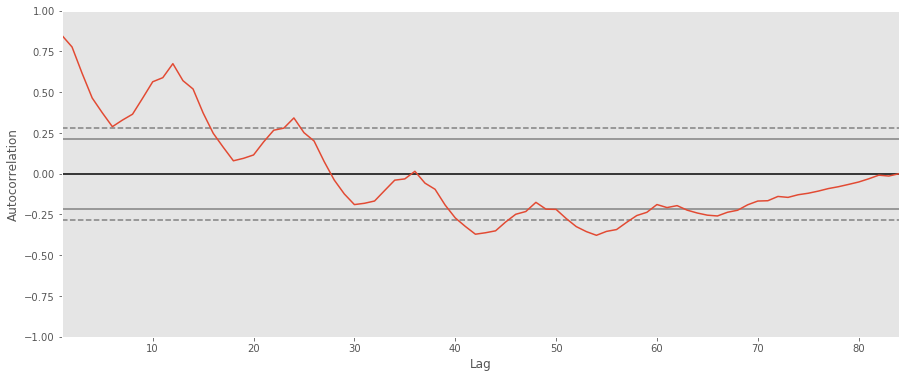

In [74]:
autocorrelation_plot(df_by_month)

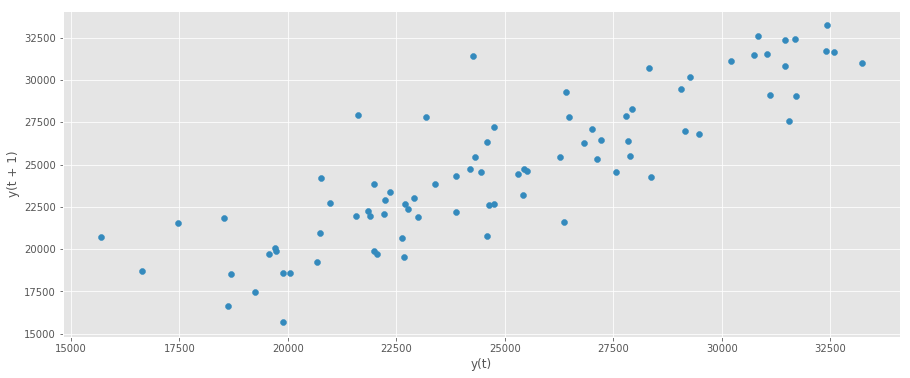

In [75]:
lag_plot(df_by_month)

```
A lag plot checks whether a data set or time series is random or not. Random data should not exhibit any identifiable structure in the lag plot. Non-random structure in the lag plot indicates that the underlying data are not random.
```

From lag plot, we see a some outliers and quite a strong linear autocorrelation between the observation cycles.

In [187]:
X = pd.DataFrame(df_by_month)
rows = X.size
months = 12

train, test = X.head(rows - months), X.tail(months)

model = ARMA(train, order=(1,0))
model_fit = model.fit()
window = model_fit.k_ar
coef = model_fit.params
print('Lag: %s' % window)

predictions = model_fit.predict(start=test.index[0], end=test.index[-1], dynamic=False)
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)


plt_happened, = plt.plot(test, label="Happened");
plt_predicted, = plt.plot(predictions, color='blue', label="Predicted");
plt.title("2016 Chicago predictions - test");
plt.legend([plt_happened, plt_predicted], ['Happened', 'Predicted']);

TypeError: Cannot cast ufunc subtract output from dtype('float64') to dtype('int64') with casting rule 'same_kind'

In [182]:
model.forecast

AttributeError: 'AR' object has no attribute 'forecast'

In [132]:
len(train)

71

In [133]:
len(train)+len(test)-1

82